# $\S$ 5.2. Piecewise Polynomials and Splines

> We assume until $\S$ 5.7 that $X$ is one-dimensional.

A piecewise polynomial function $f(X)$ is obtained by dividing the domain of $X$ into contiguous intervals and representing $f$ by a separate polynomial in each interval. FIGURE 5.1 shows two simple piecewise polynomials. The first is piecewise constant, with three basis functions:

\begin{equation}
h_1(X) = I(X \lt \xi_1), \\
h_2(X) = I(\xi_1 \le X \lt \xi_2), \\
h_3(X) = I(\xi_2 \le X \lt \xi_3). \\
\end{equation}

Since these are positive over disjoint regions, the least squares estimate of the model

\begin{equation}
f(X) = \sum_{m=1}^3 \beta_m h_m(X)
\end{equation}

amounts to $\hat\beta_m = \bar{Y}_m$, the mean of $Y$ in the $m$th region.

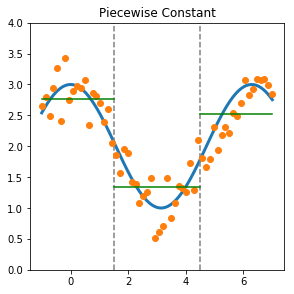

In [96]:
"""FIGURE 5.1. A piecewise constant function fit (the top left)"""
%matplotlib inline
import scipy
import scipy.linalg
import matplotlib.pyplot as plt

# Limits
x0, xi0, xi1, x1 = -1, 1.5, 4.5, 7
y0, y1 = 0, 4

# Sine line
xgrid = scipy.linspace(x0, x1, 100)
ygrid = scipy.cos(xgrid)+2
# Random sample
size_sample = 60
err_sample = scipy.randn(size_sample)*.3
x_sample = scipy.linspace(x0, x1, size_sample)
y_sample = scipy.cos(x_sample)+2+err_sample
# Plot
fig51 = plt.figure(51, figsize=(10, 10))
ax1 = fig51.add_subplot(2, 2, 1)
ax1.plot(xgrid, ygrid, linewidth=3)
ax1.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax1.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax1.set_ylim(y0, y1)
ax1.plot(x_sample, y_sample, 'o')

# Split
mask_split1 = x_sample < xi0
mask_split2 = scipy.all([x_sample >= xi0, x_sample < xi1], axis=0)
mask_split3 = xi1 <= x_sample
x_split1 = x_sample[mask_split1]
x_split2 = x_sample[mask_split2]
x_split3 = x_sample[mask_split3]
y_split1 = y_sample[mask_split1]
y_split2 = y_sample[mask_split2]
y_split3 = y_sample[mask_split3]
# Piecewise constant fit (averaging for each window)
y_split1_mean = y_split1.mean()
y_split2_mean = y_split2.mean()
y_split3_mean = y_split3.mean()
ax1.plot([x0, xi0], [y_split1_mean, y_split1_mean], color='g')
ax1.plot([xi0, xi1], [y_split2_mean, y_split2_mean], color='g')
ax1.plot([xi1, x1], [y_split3_mean, y_split3_mean], color='g')
ax1.set_title('Piecewise Constant')
plt.show()

The top right panel shows a piecewise linear fit. Three additional basis functions are needed:

\begin{equation}
h_{m+3} = h_m(X)X, \text{ for } m=1,\cdots,3.
\end{equation}

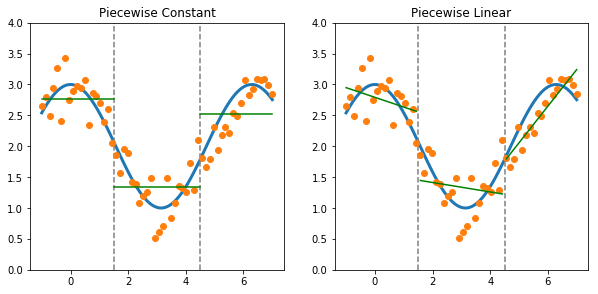

In [97]:
"""FIGURE 5.1. A piecewise linear fit (the top right)
For the univariate linear regression, see Section 3.2.3."""
# y_split1_centered = y_split1-y_split1_mean
# y_split2_centered = y_split2-y_split2_mean
# y_split3_centered = y_split3-y_split3_mean

# beta_split1 = y_split1_centered.dot(x_split1)/(x_split1*x_split1).sum()
# beta_split2 = y_split2_centered.dot(x_split2)/(x_split2*x_split2).sum()
# beta_split3 = y_split3_centered.dot(x_split3)/(x_split3*x_split3).sum()

# y_split1_hat = beta_split1*x_split1+y_split1_mean
# y_split2_hat = beta_split2*x_split2+y_split2_mean
# y_split3_hat = beta_split3*x_split3+y_split3_mean

x_split1_ones = np.vstack([x_split1, np.ones(len(x_split1))]).T
x_split2_ones = np.vstack([x_split2, np.ones(len(x_split2))]).T
x_split3_ones = np.vstack([x_split3, np.ones(len(x_split3))]).T

beta_split1, int1 = np.linalg.lstsq(x_split1_ones, y_split1.reshape(-1, 1), rcond=None)[0].flatten()
beta_split2, int2 = np.linalg.lstsq(x_split2_ones, y_split2.reshape(-1, 1), rcond=None)[0].flatten()
beta_split3, int3 = np.linalg.lstsq(x_split3_ones, y_split3.reshape(-1, 1), rcond=None)[0].flatten()

y_split1_hat = beta_split1*x_split1+int1
y_split2_hat = beta_split2*x_split2+int2
y_split3_hat = beta_split3*x_split3+int3

ax2 = fig51.add_subplot(2, 2, 2)
ax2.plot(xgrid, ygrid, linewidth=3)
ax2.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax2.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax2.set_ylim(y0, y1)
ax2.plot(x_sample, y_sample, 'o')

ax2.plot(x_split1, y_split1_hat, color='g')
ax2.plot(x_split2, y_split2_hat, color='g')
ax2.plot(x_split3, y_split3_hat, color='g')
ax2.set_title('Piecewise Linear')
fig51

Except in special cases, we would typically prefer the third panel, which is also piecewise linear, but restricted to be continuous at the two knots. These continuity restrictions lead to linear constraints on the parameters; for example,

\begin{equation}
f(\xi_1^-) = f(\xi_1^+)
\end{equation}

implies that

\begin{equation}
\beta_1 + \xi_1\beta_4 = \beta_2 + \xi_1\beta_5.
\end{equation}

In this case, since there are two restrictions, we expect to _get back_ two parameters, leaving four free parameters.

A more direct way to proceed in this case is to use a basis that incorporates the constraints:

\begin{equation}
h_1(X) = 1, \\
h_2(X) = X, \\
h_3(X) = (X - \xi_1)_+, \\
h_4(X) = (X - \xi_2)_+, \\
\end{equation}

where $t_+$ denotes the positive part. The function $h_3$ is shown in the lower right panel of FIGURE 5.1.

In [98]:
# h1 = np.ones_like(x_sample)
# h2 = np.copy(x_sample)
# h3 = np.where(x_sample < xi0, 0, x_sample-xi0)
# h4 = np.where(x_sample < xi1, 0, x_sample-xi1)
# H = np.vstack((h1, h2, h3, h4)).T

# beta = np.linalg.lstsq(H, y_sample.reshape(-1, 1), rcond=None)[0]

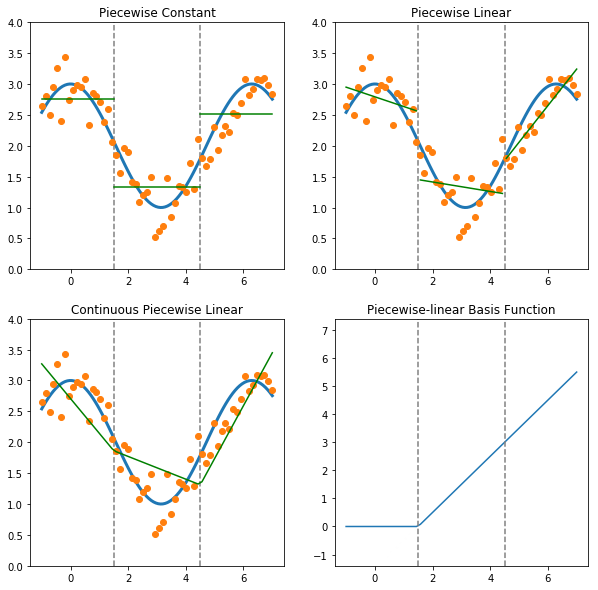

In [99]:
"""FIGURE 5.1. A continuous piecewise linear fit (the bottom left)"""
# Construct H
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = scipy.where(x_sample < xi0, 0, x_sample-xi0)
h4 = scipy.where(x_sample < xi1, 0, x_sample-xi1)
H = scipy.vstack((h1, h2, h3, h4)).T
# OLS
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat = H @ beta

ax3 = fig51.add_subplot(2, 2, 3)
ax3.plot(xgrid, ygrid, linewidth=3)
ax3.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax3.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax3.set_ylim(y0, y1)
ax3.plot(x_sample, y_sample, 'o')
ax3.plot(x_sample, y_hat, color='g')
ax3.set_title('Continuous Piecewise Linear')

ax4 = fig51.add_subplot(2, 2, 4)
ax4.plot(x_sample, h3)
ax4.plot([xi0, xi0], ax4.get_xlim(), '--', color='gray')
ax4.plot([xi1, xi1], ax4.get_xlim(), '--', color='gray')
ax4.set_ylim(ax4.get_xlim())
ax4.set_title('Piecewise-linear Basis Function')

fig51

### Cubic splines

For smoother functions, the order of the local polynomial increases. FIGURE 5.2 shows a series of piecewise-cubic polynomials fit to the same data, with increasing orders of continuity at the knots. A _cubic spline_ in the lower right panel is continuous, and has continuous first and second derivatives at the knots. Enforcing one more order of continuity would lead to a global cubic polynomial.

It is not hard to show (Exercise 5.1) that the following basis represents a cubic spline with knots at $\xi_1$ and $\xi_2$:

\begin{align}
h_1(X) &= 1, \\
h_2(X) &= X, \\
h_3(X) &= X^2, \\
h_4(X) &= X^3, \\
h_5(X) &= (X-\xi_1)_+^3, \\
h_6(X) &= (X-\xi_2)_+^3.
\end{align}

There are six basis functions corresponding to a six-dimensional linear space of functions. A quick check confirms the parameter count:

\begin{equation}
3\text{ regions } \times 4\text{ paramters per region } - 2\text{ knots } \times 3\text{ constraints per knot } = 6.
\end{equation}

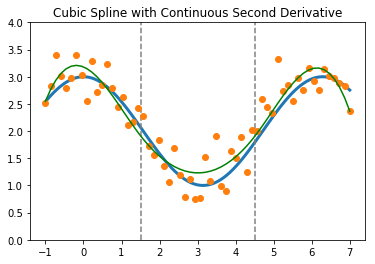

In [95]:
"""FIGURE 5.2. A cubic spline (the bottom right)"""
# Construct H
h1 = scipy.ones_like(x_sample)
h2 = scipy.copy(x_sample)
h3 = h2*h2
h4 = h3*h2
h5 = scipy.where(x_sample < xi0, 0, (x_sample-xi0)**3)
h6 = scipy.where(x_sample < xi1, 0, (x_sample-xi1)**3)
H = scipy.vstack((h1, h2, h3, h4, h5, h6)).T
# OLS
HH = H.T @ H
beta = scipy.linalg.solve(HH, H.T @ y_sample)
y_hat = H @ beta
# Plot
fig52 = plt.figure(52)
ax = fig52.add_subplot(1, 1, 1)
ax.plot(xgrid, ygrid, linewidth=3)
ax.plot([xi0, xi0], [y0, y1], '--', color='gray')
ax.plot([xi1, xi1], [y0, y1], '--', color='gray')
ax.plot(x_sample, y_sample, 'o')
ax.plot(x_sample, y_hat, color='g')
ax.set_ylim(y0, y1)
ax.set_title('Cubic Spline with Continuous Second Derivative')
plt.show()

### The general form of an order-$M$ spline

More generally, an order-$M$ spline with knots $\xi_j$, $j = 1,\cdots,K$ is a piecewise-polynomial of order M, and has continuous derivatives up to order $M-2$. A cubic spline has $M = 4$. In fact the piecewise-constant function in FIGURE 5.1 is an order-1 spline. Likewise the general form for the truncated-power basis set would be

\begin{align}
h_j(X) &= X^{j-1}, &\text{for } j = 1,\cdots,M, \\
h_{M+l}(X) &= (X-\xi_l)_+^{M-1}, &\text{for } l = 1,\cdots,K.
\end{align}

> In practice the most widely used orders are $M = 1, 2,$ and $4$.

### Regression splines

These fixed-knot splines are also known as _regression splines_. One needs to select $M$, $K$, and $\xi_l$'s.

One simple approach is to parameterize a fimaily of splines by the number of basis functions or degrees of freedom, and have the observations $x_i$ determine the positions of the knots. See the textbook (page 144) for example.